In [1]:
!pip install -q seaborn

In [2]:
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
import scipy as sc
import pandas as pd
import numpy as np
import time
from sklearn.metrics import *
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from keras.losses import binary_crossentropy
from keras.layers import Dense, Flatten, Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import r2_score
from keras import backend as K
from sklearn.model_selection import train_test_split

In [4]:
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
#         print(input_shape)
#         print(self.units)
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [5]:
data_dir = 'https://github.com/henrii1/Wind-Turbine-power-prediction-and-monitoring-using-XGboost-and-quantile-regression/blob/main/data/penmanshiel_01.xlsx?raw=true'
data = pd.read_excel(data_dir)
data.isna().sum()

def outlier_remover(dat, prop, min, max):
    d = dat
    q_low = d[prop].quantile(min)
    q_high = d[prop].quantile(max)
    return d[(d[prop]<q_high) & (d[prop]>q_low)]

d1 = {}
step = 50
i = 1
for x in range(20, 3100, step):
    d1[i] = data.iloc[((data['power']>=x)& (data['power']<x+step)).values]
    i = i + 1

d1[-2] = data.iloc[(data['power']>=2900).values]

for x in range(1, 62):
    if x <= 3:
        F = 0.96
    elif ((x > 3) and (x <= 6)):
        F = 0.84
    elif ((x > 6) and (x <= 10)):
        F = 0.93
    elif ((x > 10) and (x <= 13)):
        F = 0.95
    elif ((x > 13) and (x <= 20)):
        F = 0.90
    elif ((x > 20) and (x < 30)):
        F = 0.88
    else:
        F = 0.9
    d1[x] = outlier_remover(d1[x], 'wind speed', 0.00001, F)


df = pd.DataFrame()
for infile in range (1, 62):
    data = d1[infile]
    df = df.append(data, ignore_index = True)




In [6]:
da = df.drop(columns=['date'])
da.dropna()
scaler = MinMaxScaler(feature_range =(0, 1))
data_ = scaler.fit_transform(da)
data_1 = np.array(da)
data_x_ = data_1[:, :-1]
data_y_ = data_1[:, -1]
data_x = data_[:, :-1]
data_y = data_[:, -1]

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size = 0.001, random_state = 1)
x_train_, x_test_, y_train_, y_test_ = train_test_split(data_x_, data_y_, test_size = 0.001, random_state = 1)

In [7]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    print(f'xgboost_RMSE:{rmse}')
    print(f'xgboost_MAE:{mae}')
    print(f'xgboost_R_SCORE:{r2}')

In [8]:
best_xgb_model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)


best_xgb_model.fit(x_train_,y_train_)
pred1 = best_xgb_model.predict(x_test_)

xgboost_model = eval_metrics(y_test_, pred1)
print(f' xgboost cummulative accuracy is: {xgboost_model}')

[18:38:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgboost_RMSE:51.85204240166102
xgboost_MAE:36.99446443532558
xgboost_R_SCORE:0.993687350590727
 xgboost cummulative accuracy is: None


In [9]:
best_xgb_model_ = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)
best_xgb_model_.fit(x_train,y_train)
pred1_ = best_xgb_model_.predict(x_test)

#xgboost_model_ = eval_metrics(y_test_, pred1_)
#print(f' xgboost cummulative accuracy is: {xgboost_model}')

[18:40:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [10]:
print(f'the ground truth result is: {y_test_}')

the ground truth result is: [ 421.1114624  2047.52675445  118.00459256  152.85614433 1334.0157959
   65.34854271 1584.86193034  249.38588918  962.33074341  631.83483378
 1189.01029053   78.75710065  371.9245818   800.08827209  967.92466024
  926.16961263  970.1651413  1919.74383138   71.74910069  871.44896952
  145.26360881 1442.80150757 1764.25617269 1801.09806722  674.50112101
  626.05876973 1069.48064372 1003.21468506  446.95342649  396.36229858
  722.20535496 2043.94440511   36.61119537  254.01232707  280.78858782
 2041.0682902  2049.41454264  332.65550868]


In [11]:
print(f'the ground truth result is: {y_test}')

the ground truth result is: [0.19502371 0.98580298 0.04765014 0.06459532 0.63888686 0.02204825
 0.76085074 0.11152904 0.4581699  0.29747951 0.56838375 0.02856762
 0.17110856 0.379286   0.46088972 0.440588   0.46197906 0.92367365
 0.02516027 0.41398228 0.06090375 0.69177956 0.84807401 0.8659869
 0.31822428 0.29467113 0.51026725 0.47804808 0.20758833 0.18299042
 0.34141855 0.9840612  0.00807587 0.11377846 0.12679734 0.98266281
 0.98672084 0.15201555]


In [12]:
print(f"xgboost predicted results is: {pred1_}")

xgboost predicted results is: [0.22253844 0.9757898  0.03231555 0.06085983 0.6189611  0.01963761
 0.7597838  0.11191139 0.46628013 0.29282093 0.5808039  0.03382155
 0.16005108 0.35531473 0.4496679  0.40669212 0.45987815 0.86529434
 0.01893958 0.41610408 0.06288832 0.65634453 0.9002584  0.80905557
 0.29925144 0.32344514 0.4864298  0.481574   0.22727972 0.18377069
 0.3126849  0.9846465  0.04332054 0.12138847 0.1311276  0.9733738
 0.98379326 0.15011671]


In [13]:
model1_1A = Sequential()
model1_1A.add(Dense(128, input_dim = (3)))
model1_1A.add(RBFLayer(64, 0.5))
model1_1A.add(Dense(1, activation='sigmoid', name= 'output'))
model1_1A.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               512       
                                                                 
 rbf_layer (RBFLayer)        (None, 64)                8192      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [14]:
model1_1A.compile(optimizer='adam',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [15]:
rbf_model = model1_1A.fit(x_train, y_train, epochs=50, batch_size=50, verbose=1)


rbf_pred1 = model1_1A.predict(x_test)
r2=r2_score(y_test, rbf_pred1)
print(r2)

Epoch 1/50
745/745 [==============================] - 5s 5ms/step - loss: 0.4032 - root_mean_squared_error: 0.0754 - mean_absolute_error: 0.0388
Epoch 2/50
745/745 [==============================] - 4s 5ms/step - loss: 0.3891 - root_mean_squared_error: 0.0278 - mean_absolute_error: 0.0211
Epoch 3/50
745/745 [==============================] - 4s 5ms/step - loss: 0.3887 - root_mean_squared_error: 0.0267 - mean_absolute_error: 0.0200
Epoch 4/50
745/745 [==============================] - 4s 5ms/step - loss: 0.3885 - root_mean_squared_error: 0.0261 - mean_absolute_error: 0.0194
Epoch 5/50
745/745 [==============================] - 4s 5ms/step - loss: 0.3884 - root_mean_squared_error: 0.0256 - mean_absolute_error: 0.0188
Epoch 6/50
745/745 [==============================] - 4s 5ms/step - loss: 0.3883 - root_mean_squared_error: 0.0255 - mean_absolute_error: 0.0187
Epoch 7/50
745/745 [==============================] - 4s 5ms/step - loss: 0.3883 - root_mean_squared_error: 0.0251 - mean_absolute

In [16]:
print(f"the rbf predicted result is: {rbf_pred1}")

the rbf predicted result is: [[0.21974814]
 [0.9614229 ]
 [0.03611299]
 [0.06426561]
 [0.60237205]
 [0.0223726 ]
 [0.75502545]
 [0.1103684 ]
 [0.4528381 ]
 [0.29276723]
 [0.5794483 ]
 [0.03788126]
 [0.1648362 ]
 [0.35360903]
 [0.4493586 ]
 [0.39194778]
 [0.4695508 ]
 [0.8592712 ]
 [0.02350235]
 [0.41889924]
 [0.05335715]
 [0.6420195 ]
 [0.90076375]
 [0.786665  ]
 [0.3068056 ]
 [0.32005045]
 [0.4776222 ]
 [0.4793443 ]
 [0.22922069]
 [0.17464912]
 [0.30654436]
 [0.97655845]
 [0.00217727]
 [0.12641034]
 [0.1334976 ]
 [0.9784558 ]
 [0.9842967 ]
 [0.15362284]]


In [17]:
model1_2A = Sequential()
model1_2A.add(Dense(3, activation='relu', input_dim=(3)))
model1_2A.add(Dense(32, activation='relu'))
model1_2A.add(Dense(64, activation='relu'))
model1_2A.add(Dense(32, activation='relu'))
model1_2A.add(Dense(1, name='output'))
model1_2A.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
 dense_2 (Dense)             (None, 32)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________


In [18]:
model1_2A.compile(optimizer='adam',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

mlp_model = model1_2A.fit(x_train, y_train, epochs=50, batch_size=50, verbose=1)

y_pred1_2A = model1_2A.predict(x_test)

Epoch 1/50
745/745 [==============================] - 2s 2ms/step - loss: 0.4724 - root_mean_squared_error: 0.1669 - mean_absolute_error: 0.0954
Epoch 2/50
745/745 [==============================] - 2s 2ms/step - loss: 0.4503 - root_mean_squared_error: 0.1414 - mean_absolute_error: 0.0852
Epoch 3/50
745/745 [==============================] - 2s 2ms/step - loss: 0.4148 - root_mean_squared_error: 0.0808 - mean_absolute_error: 0.0554
Epoch 4/50
745/745 [==============================] - 2s 2ms/step - loss: 0.4357 - root_mean_squared_error: 0.1117 - mean_absolute_error: 0.0702
Epoch 5/50
745/745 [==============================] - 2s 2ms/step - loss: 0.4095 - root_mean_squared_error: 0.0632 - mean_absolute_error: 0.0418
Epoch 6/50
745/745 [==============================] - 2s 2ms/step - loss: 0.4049 - root_mean_squared_error: 0.0527 - mean_absolute_error: 0.0341
Epoch 7/50
745/745 [==============================] - 2s 2ms/step - loss: 0.4616 - root_mean_squared_error: 0.1503 - mean_absolute

In [19]:
r2_mlp = r2_score(y_test, y_pred1_2A)
print(r2_mlp)

0.9952142317682233


In [20]:
print(f" the predicted values for the mlp model is: {y_pred1_2A}")

 the predicted values for the mlp model is: [[0.22559515]
 [0.97398174]
 [0.03816205]
 [0.06860422]
 [0.6232672 ]
 [0.02478287]
 [0.75677097]
 [0.11410046]
 [0.4626762 ]
 [0.2971997 ]
 [0.5816859 ]
 [0.04187462]
 [0.1633722 ]
 [0.357289  ]
 [0.45159817]
 [0.39780128]
 [0.47420323]
 [0.8710221 ]
 [0.01839267]
 [0.43672514]
 [0.06255247]
 [0.6672971 ]
 [0.90735734]
 [0.813557  ]
 [0.3098313 ]
 [0.3278647 ]
 [0.48692417]
 [0.48456848]
 [0.23686081]
 [0.17450307]
 [0.3165763 ]
 [0.97952545]
 [0.01200889]
 [0.12721366]
 [0.13510591]
 [0.9854983 ]
 [0.97962976]
 [0.15654367]]


In [21]:
#from pandas import ExcelWriter

#writer = ExcelWriter('filtered_data_2.xlsx')
#df.to_excel(writer)
#writer.save()

In [22]:
#def plot_loss(xgboost_model):
  #plt.plot(xgboost_model.history['rmse'], label='rmse')
  #plt.plot(xgboost_model.history['mae'], label='mae')
  #plt.plot(xgboost_model.history['r2'], label='r2')
  #plt.ylim([0, 10])
  #plt.xlabel('Epoch')
  #plt.ylabel('Error')

#plot_loss(xgboost_model)

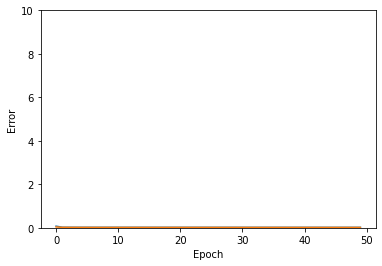

In [23]:
def plot_loss(rbf_model):
  plt.plot(rbf_model.history['root_mean_squared_error'], label='rmse')
  plt.plot(rbf_model.history['mean_absolute_error'], label='mae')
  #plt.plot(r2.history['r2'], label='r2')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(rbf_model)

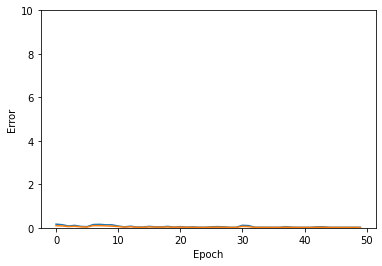

In [24]:
def plot_loss(mlp_model):
  plt.plot(mlp_model.history['root_mean_squared_error'], label='rmse')
  plt.plot(mlp_model.history['mean_absolute_error'], label='mae')
 # plt.plot(r2_mlp.history['r2'], label='r2')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(mlp_model)

In [25]:
xgboost_predicted = best_xgb_model.predict(data_x_)

In [26]:
rbf_predicted = model1_1A.predict(data_x)

In [27]:
mlp_predicted = model1_2A.predict(data_x)

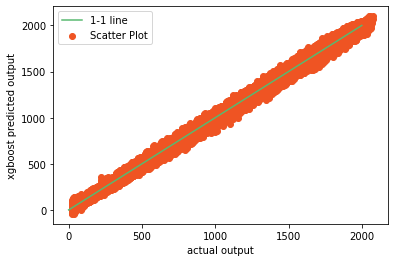

In [28]:
#plt.plot(1, 1, color='#58b970', label='1-1 line')
x = [0, 500, 1000, 1500, 2000]
y = [0, 500, 1000, 1500, 2000]
plt.plot(x, y, color='#58b970', label='1-1 line')
plt.scatter(data_y_, xgboost_predicted, c='#ef5423', label='Scatter Plot')

plt.xlabel('actual output')
plt.ylabel('xgboost predicted output')
plt.legend()
plt.show()

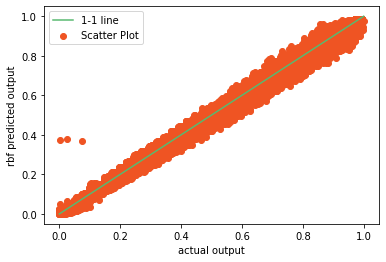

In [29]:
x = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
y = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
plt.plot(x, y, color='#58b970', label='1-1 line')

plt.scatter(data_y, rbf_predicted, c='#ef5423', label='Scatter Plot')

plt.xlabel('actual output')
plt.ylabel('rbf predicted output')
plt.legend()
plt.show()

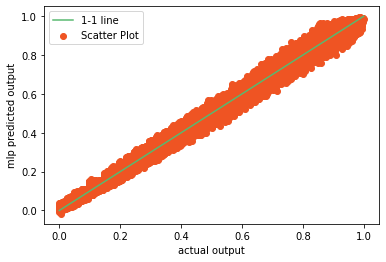

In [30]:
x = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
y = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
plt.plot(x, y, color='#58b970', label='1-1 line')

plt.scatter(data_y, mlp_predicted, c='#ef5423', label='Scatter Plot')

plt.xlabel('actual output')
plt.ylabel('mlp predicted output')
plt.legend()
plt.show()

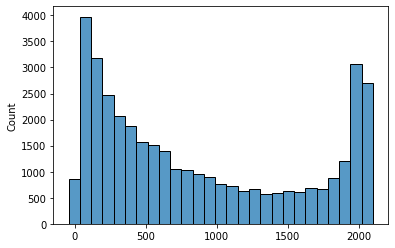

In [31]:
import seaborn as sns
sns.histplot(xgboost_predicted)

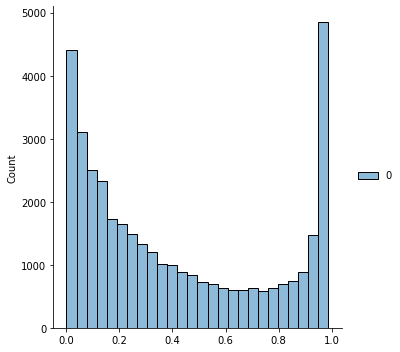

In [32]:
sns.displot(rbf_predicted)

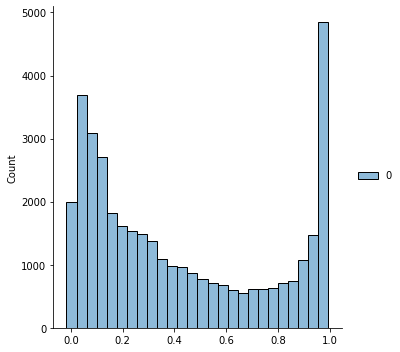

In [33]:
sns.displot(mlp_predicted)

In [34]:
data_x_

array([[  3.65238186, 191.27473109,   1.77366832],
       [  4.00556021, 202.14916301,   1.55633544],
       [  4.18138571, 237.30573411,   1.35934096],
       ...,
       [ 21.0666296 , 216.15229219,  16.87581105],
       [ 22.27134905, 214.69578498,  17.76205676],
       [ 22.75567935, 203.1640966 ,  17.92966671]])

In [35]:
d = {'wind speed': data_x_[:, 0], 'power output':xgboost_predicted }
e = pd.DataFrame(data=d)
e

,wind speed,power output
0,3.652382,9.716474
1,4.005560,39.847260
2,4.181386,46.928082
3,4.154462,54.208675
4,3.826013,18.829588
...,...,...
37242,13.102957,2019.781494
37243,13.522677,2011.738647
37244,21.066630,2068.450195
37245,22.271349,2097.968994


In [36]:
from pandas import ExcelWriter

writer = ExcelWriter('model_data_2.xlsx')
e.to_excel(writer)
writer.save()